In [4]:
import numpy as np
import torch
import gif
import matplotlib.pyplot as plt
import pytorch_lightning as pl 
from pathlib import Path
import yaml
import matplotlib.ticker as ticker
import matplotlib.colors as colors

from matplotlib.tri import Triangulation as triang

from scipy.io import loadmat

from scipy.interpolate import LinearNDInterpolator as interp_lin
from gcn_network import load_checkpoint

import seaborn

seaborn.set_style("darkgrid")

In [5]:
model_checkpoint_path = Path(r'/Users/kdoh/Library/CloudStorage/OneDrive-UCB-O365/Documents/Research/QuadConv/lightning_logs/gcn-examples/mesh-gcn/gcn_pool/version_11')
data_path = Path(r'/Users/kdoh/Library/CloudStorage/OneDrive-UCB-O365/Documents/Research/QuadConv/data/ignition_mesh')
model, dataset, locations = load_checkpoint(model_checkpoint_path, data_path)

In [6]:
save_path = model_checkpoint_path

processed_data = model(dataset).detach().numpy()

difference_norm = torch.sqrt((dataset - processed_data)**2)

relative_difference_norm = difference_norm / torch.sqrt((dataset)**2)

(-0.05, 1.05, -0.05, 1.05)

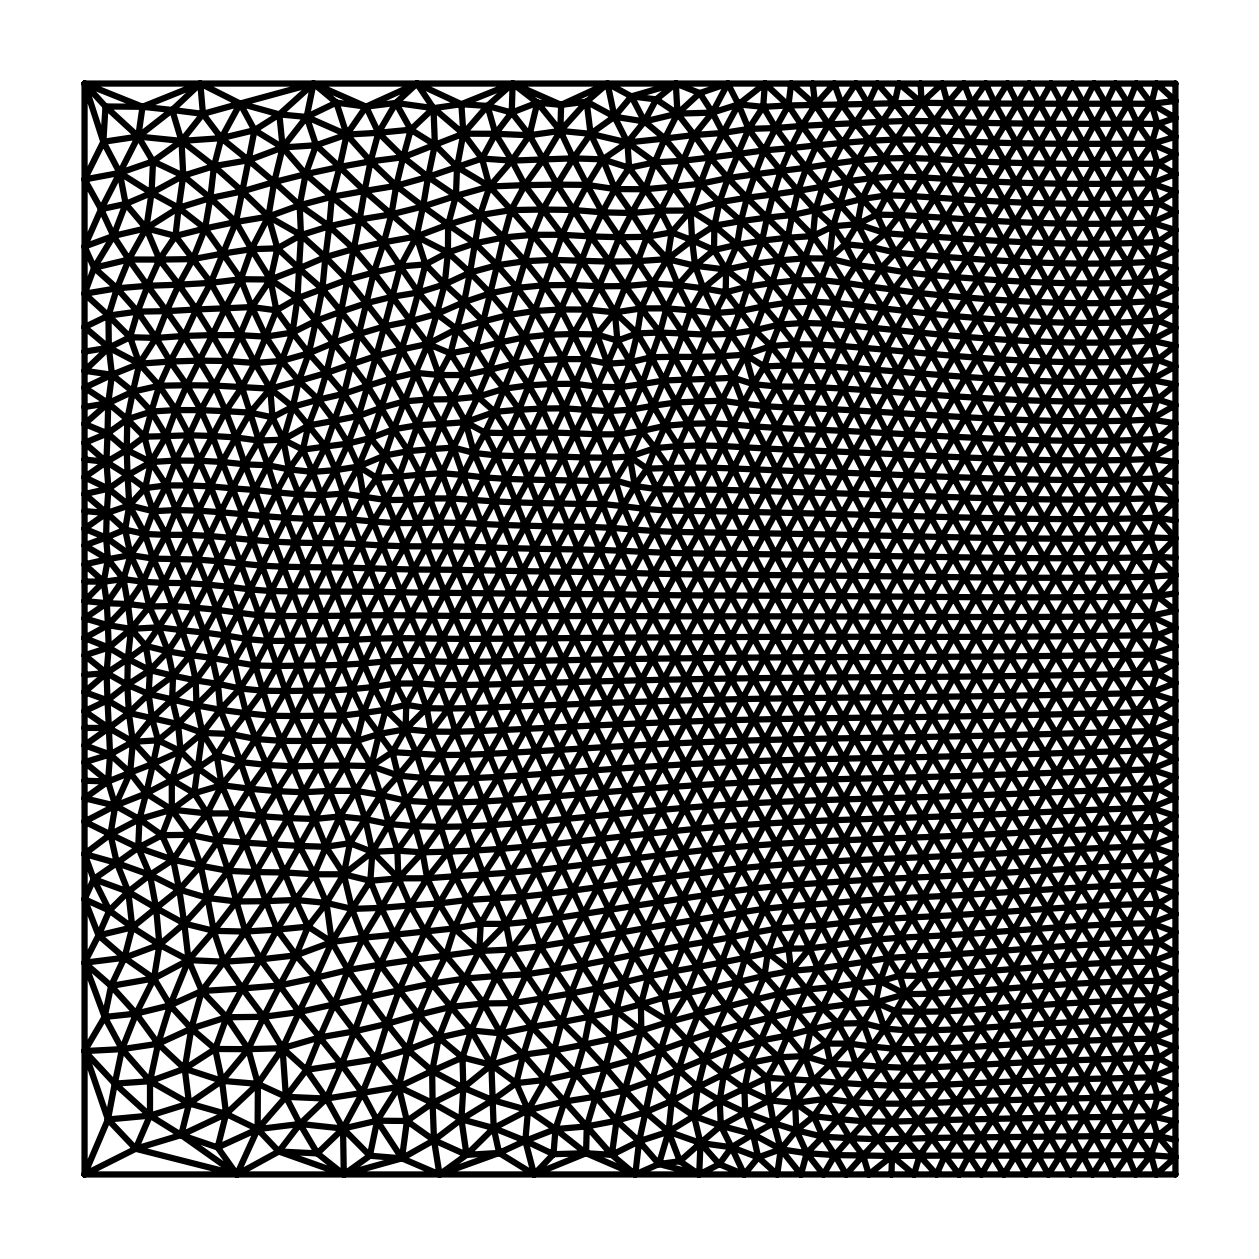

In [4]:

#mesh_scatter = axs[1,0].scatter(locations[:,0], locations[:,1], c = 'black', marker='.', s = 1)
#axs[1,0].set_aspect('equal')

flow_tri = triang(locations[:,0], locations[:,1])

fig_tri = plt.figure(figsize=(4,4), dpi=300)

ax_tri = fig_tri.add_axes([0,0,1,1])

ax_tri.triplot(flow_tri, color='black')

ax_tri.axis('off')

#fig_tri.savefig(save_path / 'ignition_mesh.pdf', format='pdf')


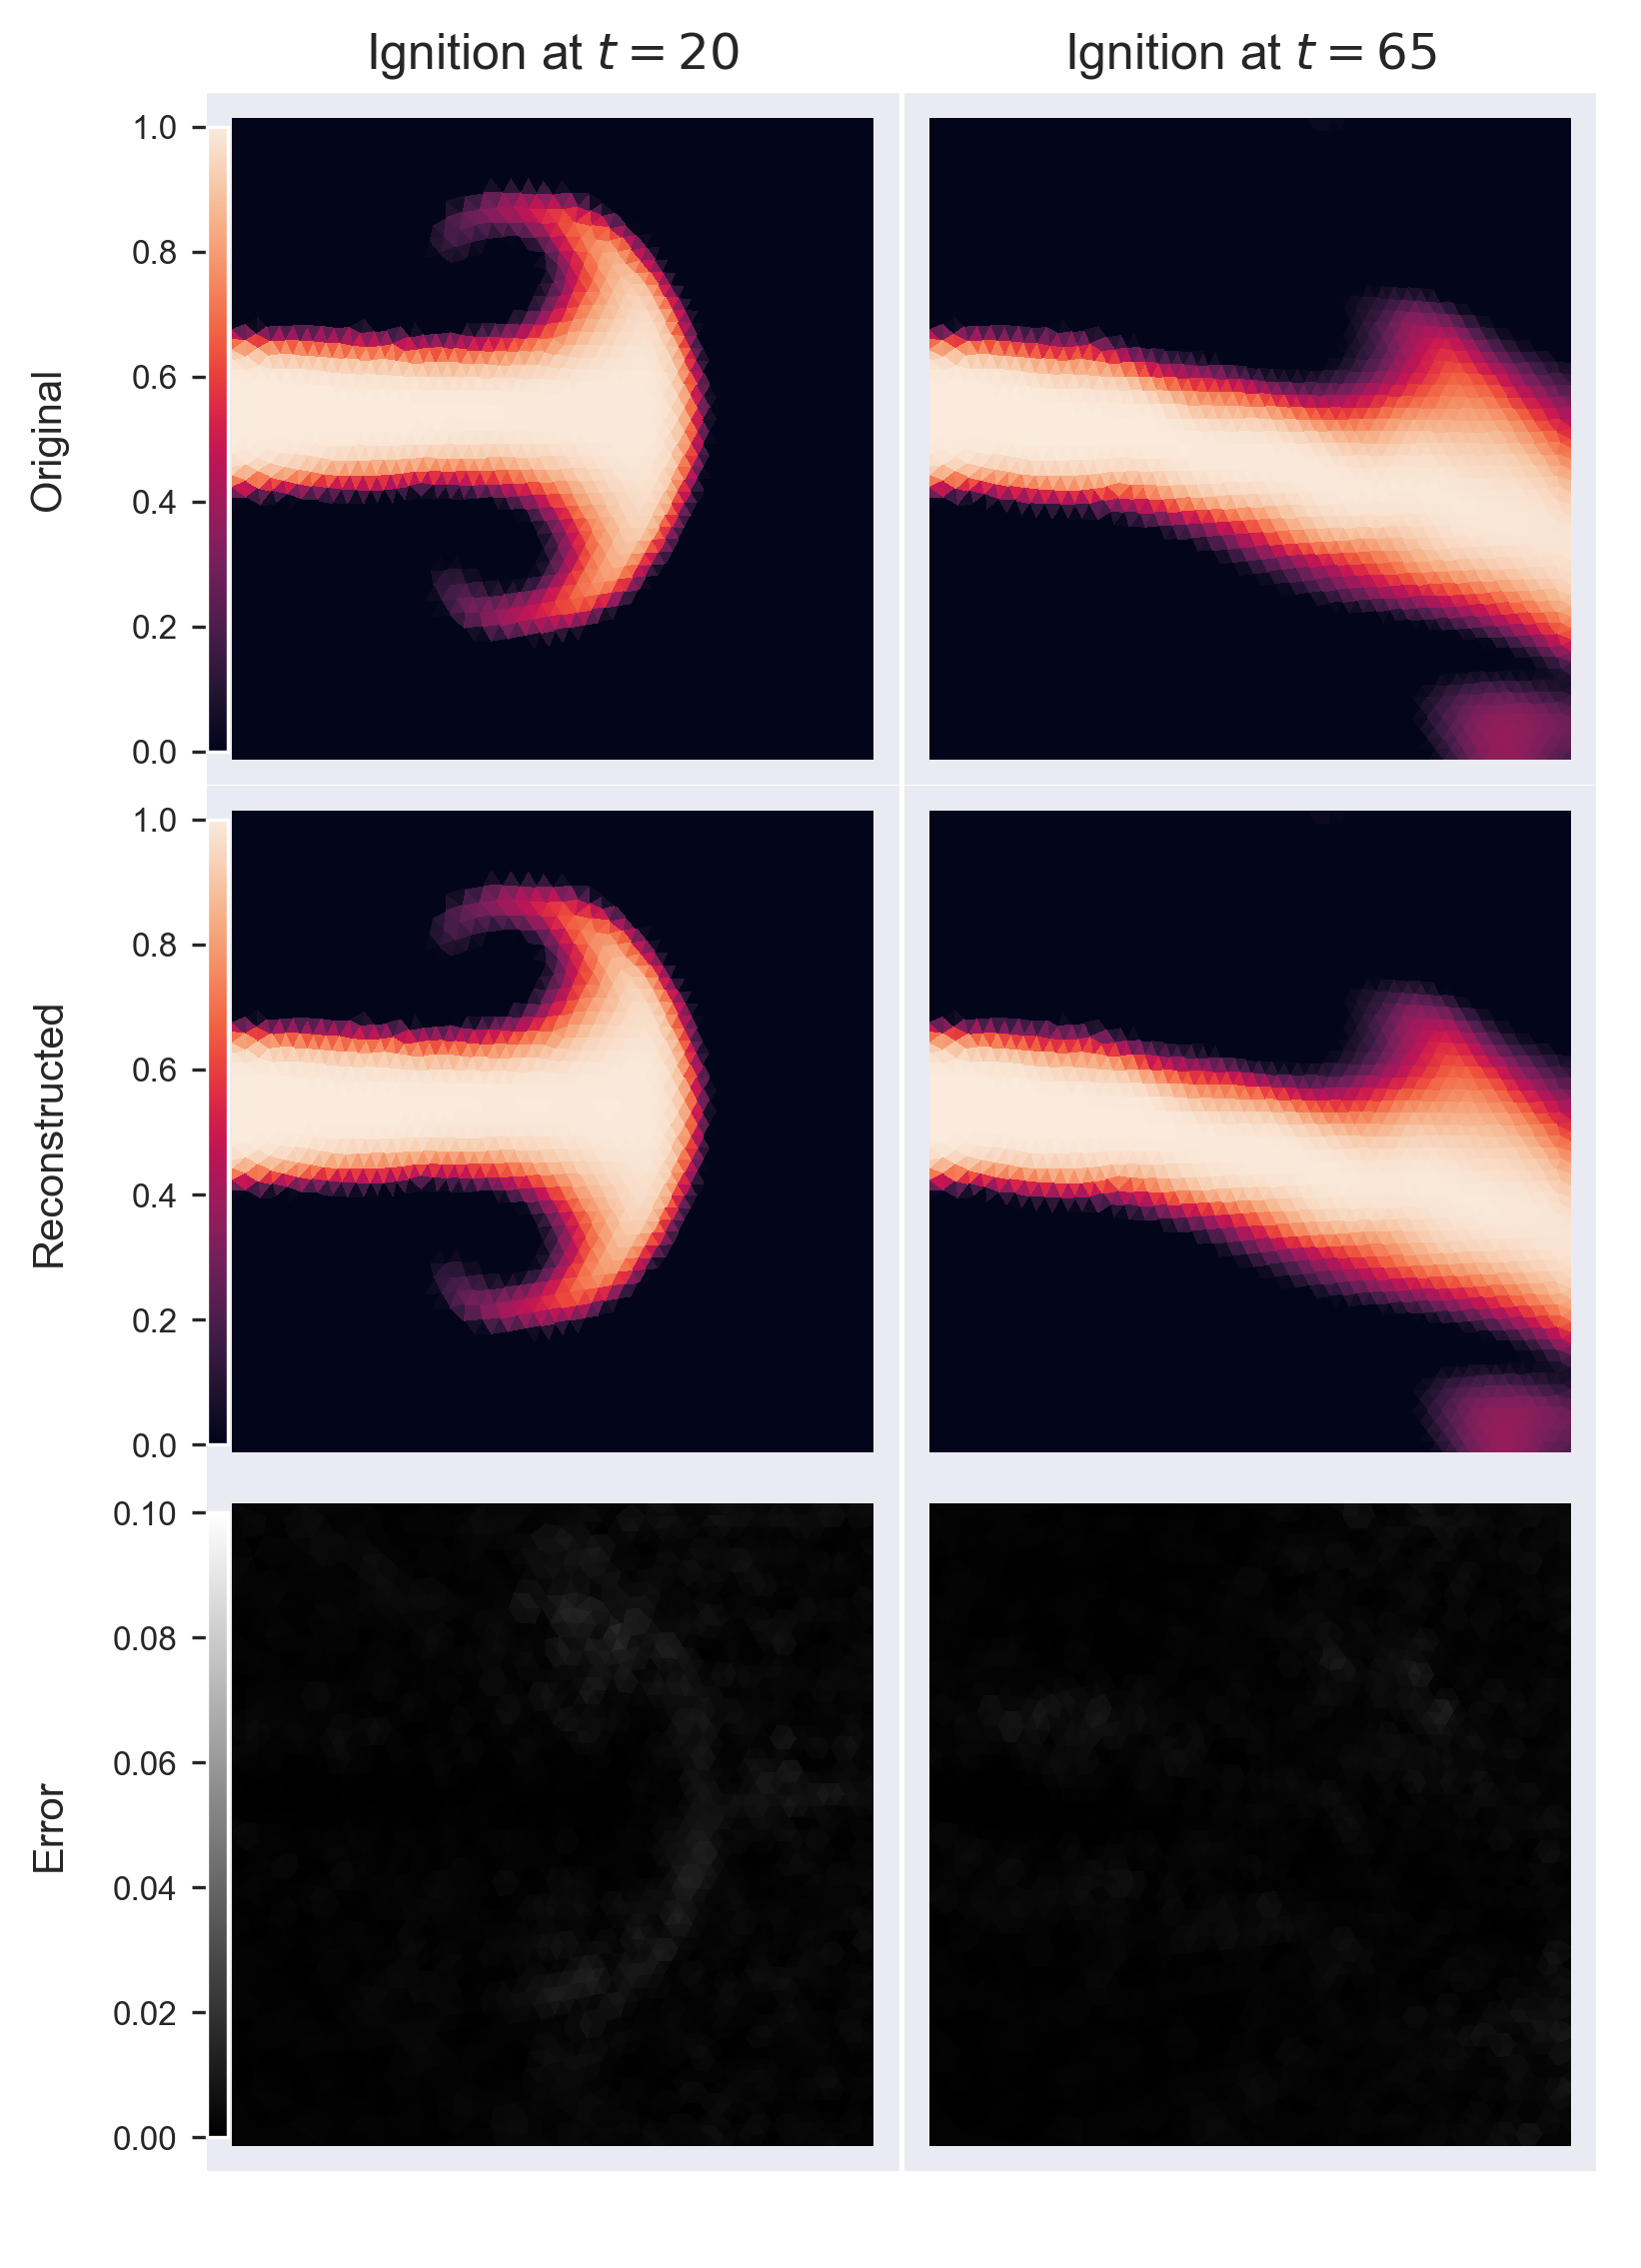

In [8]:
time_steps = [20 , 65]

max_disp = torch.max(dataset)
min_disp = torch.min(dataset)

max_disp = 1
min_disp = 0

my_map = seaborn.color_palette(palette='rocket', as_cmap=True)

error_map = seaborn.color_palette(palette='gray', as_cmap=True)


fig = plt.figure(figsize=(6,9), dpi=300)

axs = [fig.add_subplot(3,2,i+1) for i in range(6)]

max_x = torch.max(locations[:,0])
max_y = torch.max(locations[:,1])

flow_tri = triang(locations[:,0], locations[:,1])

map_it0 = axs[0].tripcolor(flow_tri, dataset[time_steps[0],0,:], facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

map_it2 = axs[2].tripcolor(flow_tri, processed_data[time_steps[0],0,:], facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

map_it4 = axs[4].tripcolor(flow_tri, difference_norm[time_steps[0],0,:], facecolors=None, shading='flat', vmin=0, vmax=0.1, cmap= error_map)

axs[1].tripcolor(flow_tri, dataset[time_steps[1],0,:], facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

axs[3].tripcolor(flow_tri, processed_data[time_steps[1],0,:], facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

axs[5].tripcolor(flow_tri, difference_norm[time_steps[1],0,:], facecolors=None, shading='flat', vmin=0, vmax=0.1, cmap= error_map)

# Tweak all the axes 
for ax in axs:
    ax.label_outer()
    ax.set_aspect('equal')
    ax.margins(x=0.04, y = 0.04)
    ax.spines['top'].set_color('none')
    ax.spines['bottom'].set_color('none')
    ax.spines['left'].set_color('none')
    ax.spines['right'].set_color('none')
    ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    #ax.set_axis_off()   

plt.subplots_adjust(hspace = 0.001, wspace = 0.001)

#axs[1].set_axis_off()   
#axs[3].set_axis_off()   
#axs[5].set_axis_off()   

# Make colorbars 
bbox = axs[0].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0] -0.00, pos[1] + 0.0125 , pos[2]*0.03, pos[3] - 0.025])
plt.colorbar(map_it0, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

bbox = axs[2].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0]-0.000, pos[1] + 0.0125, pos[2]*0.03, pos[3] - 0.025])
plt.colorbar(map_it2, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)

bbox = axs[4].get_position()
pos = bbox.bounds
ax_cb = fig.add_axes([pos[0]+0.00, pos[1] + 0.0125, pos[2]*0.03, pos[3] - 0.025])
plt.colorbar(map_it4, cax=ax_cb)
ax_cb.yaxis.set_ticks_position('left')
ax_cb.tick_params(labelsize = 8)



axs[0].set_title(r'Ignition at $t=20$')

axs[1].set_title(r'Ignition at $t=65$')


axs[0].yaxis.set_label_coords(-0.2,0.5)
axs[0].set_ylabel('Original')
axs[2].yaxis.set_label_coords(-0.2,0.5)
axs[2].set_ylabel('Reconstructed')
axs[4].yaxis.set_label_coords(-0.2,0.5)
axs[4].set_ylabel('Error')


fig.savefig(save_path / 'ignition_viz_results.pdf', format='pdf', bbox_inches='tight', dpi=300)


In [6]:

def make_gif_single(dataset, locations, save_path):

    #gif frame closure
    @gif.frame
    def plot(i,j):
        plot_data_single(dataset[i,j,:], locations)


    #build frames
    for j in range(dataset.shape[1]):
        frames = [plot(i,j) for i in range(dataset.shape[0])]

        this_save = save_path / f'siam_cse_orig_neg1_invis_channel_{j}.gif'

        #save gif
        gif.save(frames, str(this_save), duration=50)

    return


def plot_data_single(dataset, locations):

    max_disp = torch.max(dataset)
    min_disp = torch.min(dataset)

    max_disp = 1
    min_disp = -1

    my_map = seaborn.color_palette(palette='rocket', as_cmap=True)

    #fig = plt.figure(figsize=(3,3), dpi=300)

    #axs = [fig.add_subplot(1,1,i+1) for i in range(1)]

    fig,axs = plt.subplots(1,1, figsize=(3,3), dpi=300, facecolor="None")

    max_x = torch.max(locations[:,0])
    max_y = torch.max(locations[:,1])

    flow_tri = triang(locations[:,0], locations[:,1])

    map_it0 = axs.tripcolor(flow_tri, dataset, facecolors=None, shading='gouraud', vmin=min_disp, vmax=max_disp, cmap= my_map)

    # Tweak all the axes 
    axs.label_outer()
    axs.set_aspect('equal')
    axs.margins(x=0.04, y = 0.04)
    axs.spines['top'].set_color('none')
    axs.spines['bottom'].set_color('none')
    axs.spines['left'].set_color('none')
    axs.spines['right'].set_color('none')
    axs.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
    #ax.set_axis_off()   

    plt.subplots_adjust(hspace = 0.001, wspace = 0.001) 

    # Make colorbars 
    #bbox = axs.get_position()
    #pos = bbox.bounds
    #ax_cb = fig.add_axes([pos[0] -0.00, pos[1] + 0.0125 , pos[2]*0.03, pos[3] - 0.025])
    #plt.colorbar(map_it0, cax=ax_cb)
    #ax_cb.yaxis.set_ticks_position('left')
    #ax_cb.tick_params(labelsize = 8)

    #axs[0].yaxis.set_label_coords(-0.2,0.5)
    #axs[0].set_ylabel('Original')

In [7]:
make_gif_single(dataset, locations, save_path)

In [8]:
print(str((save_path / f'channel_{1}.gif')))

print(save_path)

this_save = save_path /  'channel_1.gif'

print(str(this_save))

/Users/kdoh/Library/CloudStorage/OneDrive-UCB-O365/Documents/Research/QuadConv/lightning_logs/gcn-examples/mesh-gcn/gcn_pool/version_11/channel_1.gif
/Users/kdoh/Library/CloudStorage/OneDrive-UCB-O365/Documents/Research/QuadConv/lightning_logs/gcn-examples/mesh-gcn/gcn_pool/version_11
/Users/kdoh/Library/CloudStorage/OneDrive-UCB-O365/Documents/Research/QuadConv/lightning_logs/gcn-examples/mesh-gcn/gcn_pool/version_11/channel_1.gif


In [9]:

def make_gif_panel(dataset, processed_data, difference_norm, locations, save_path):

    #gif frame closure
    @gif.frame
    def plot(i,j):
        plot_data_panel(dataset[i,j,:], processed_data[i,j,:], difference_norm[i,j,:], locations)


    #build frames
    for j in range(dataset.shape[1]):
        frames = [plot(i,j) for i in range(dataset.shape[0])]

        this_save = save_path / f'siam_cse_neg1_channel_{j}.gif'

        #save gif
        gif.save(frames, str(this_save), duration=50)

    return


def plot_data_panel(dataset, processed_data, difference_norm, locations):

    max_disp = torch.max(dataset)
    min_disp = torch.min(dataset)

    max_disp = 1
    min_disp = 0

    my_map = seaborn.color_palette(palette='rocket', as_cmap=True)

    error_map = seaborn.color_palette(palette='gray', as_cmap=True)


    fig = plt.figure(figsize=(3,9), dpi=300)

    axs = [fig.add_subplot(3,1,i+1) for i in range(3)]

    max_x = torch.max(locations[:,0])
    max_y = torch.max(locations[:,1])

    flow_tri = triang(locations[:,0], locations[:,1])

    map_it0 = axs[0].tripcolor(flow_tri, dataset, facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

    map_it2 = axs[1].tripcolor(flow_tri, processed_data, facecolors=None, shading='flat', vmin=min_disp, vmax=max_disp, cmap= my_map)

    map_it4 = axs[2].tripcolor(flow_tri, difference_norm, facecolors=None, shading='flat', vmin=0, vmax=0.1, cmap= error_map)

    # Tweak all the axes 
    for ax in axs:
        ax.label_outer()
        ax.set_aspect('equal')
        ax.margins(x=0.04, y = 0.04)
        ax.spines['top'].set_color('none')
        ax.spines['bottom'].set_color('none')
        ax.spines['left'].set_color('none')
        ax.spines['right'].set_color('none')
        ax.tick_params(labelcolor='w', top=False, bottom=False, left=False, right=False)
        #ax.set_axis_off()   

    plt.subplots_adjust(hspace = 0.001, wspace = 0.001) 

    # Make colorbars 
    bbox = axs[0].get_position()
    pos = bbox.bounds
    ax_cb = fig.add_axes([pos[0] -0.00, pos[1] + 0.0125 , pos[2]*0.03, pos[3] - 0.025])
    plt.colorbar(map_it0, cax=ax_cb)
    ax_cb.yaxis.set_ticks_position('left')
    ax_cb.tick_params(labelsize = 8)

    bbox = axs[1].get_position()
    pos = bbox.bounds
    ax_cb = fig.add_axes([pos[0]-0.000, pos[1] + 0.0125, pos[2]*0.03, pos[3] - 0.025])
    plt.colorbar(map_it2, cax=ax_cb)
    ax_cb.yaxis.set_ticks_position('left')
    ax_cb.tick_params(labelsize = 8)

    bbox = axs[2].get_position()
    pos = bbox.bounds
    ax_cb = fig.add_axes([pos[0]+0.00, pos[1] + 0.0125, pos[2]*0.03, pos[3] - 0.025])
    plt.colorbar(map_it4, cax=ax_cb)
    ax_cb.yaxis.set_ticks_position('left')
    ax_cb.tick_params(labelsize = 8)

    axs[0].yaxis.set_label_coords(-0.2,0.5)
    axs[0].set_ylabel('Original')
    axs[1].yaxis.set_label_coords(-0.2,0.5)
    axs[1].set_ylabel('Reconstructed')
    axs[2].yaxis.set_label_coords(-0.2,0.5)
    axs[2].set_ylabel('Error')

In [10]:
make_gif_panel(dataset, processed_data, difference_norm, locations, save_path)

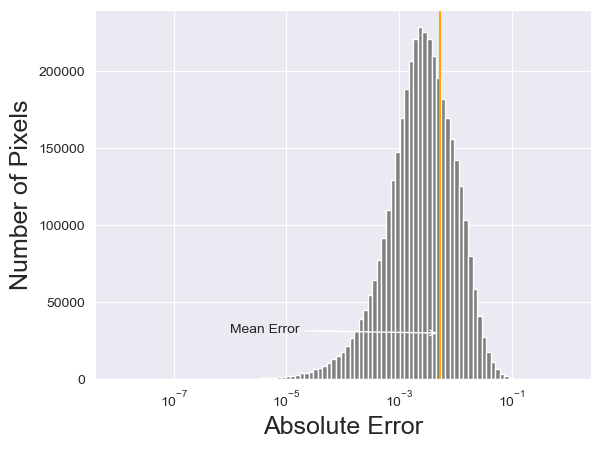

In [10]:

plt.hist(difference_norm.flatten(),bins=np.logspace(np.log10(1e-8),np.log10(1.0), 100), log=False, color='grey')
plt.gca().set_xscale("log")
plt.ylabel('Number of Pixels', fontsize=18)
plt.xlabel('Absolute Error', fontsize=18)

plt.axvline(x = torch.mean(difference_norm), color = 'orange', label = 'Mean Error')
plt.annotate('Mean Error' , (torch.mean(difference_norm),3e4), xytext=(1e-6, 3e4), textcoords='data', arrowprops=dict(arrowstyle="->",
                            connectionstyle="arc3"))

plt.savefig(save_path / 'ignition_abs_error_histogram.pdf', format='pdf')


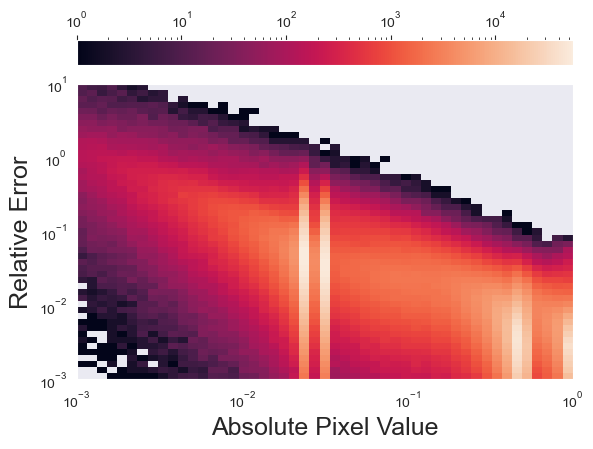

In [6]:
xbin = np.logspace(np.log10(1e-3),np.log10(1.), 50)
ybin = np.logspace(np.log10(1e-3),np.log10(10), 50)

plt.hist2d( torch.abs(dataset.flatten()).numpy(), relative_difference_norm.flatten().numpy(), bins=[xbin,ybin], norm = colors.LogNorm())

plt.gca().set_xscale("log")
plt.gca().set_yscale("log")
plt.colorbar(location='top')
plt.xlabel('Absolute Pixel Value', fontsize=18)
plt.ylabel('Relative Error', fontsize=18)

plt.savefig(save_path / 'ignition_abs_rel_histogram.pdf', format='pdf')

<Figure size 640x480 with 0 Axes>

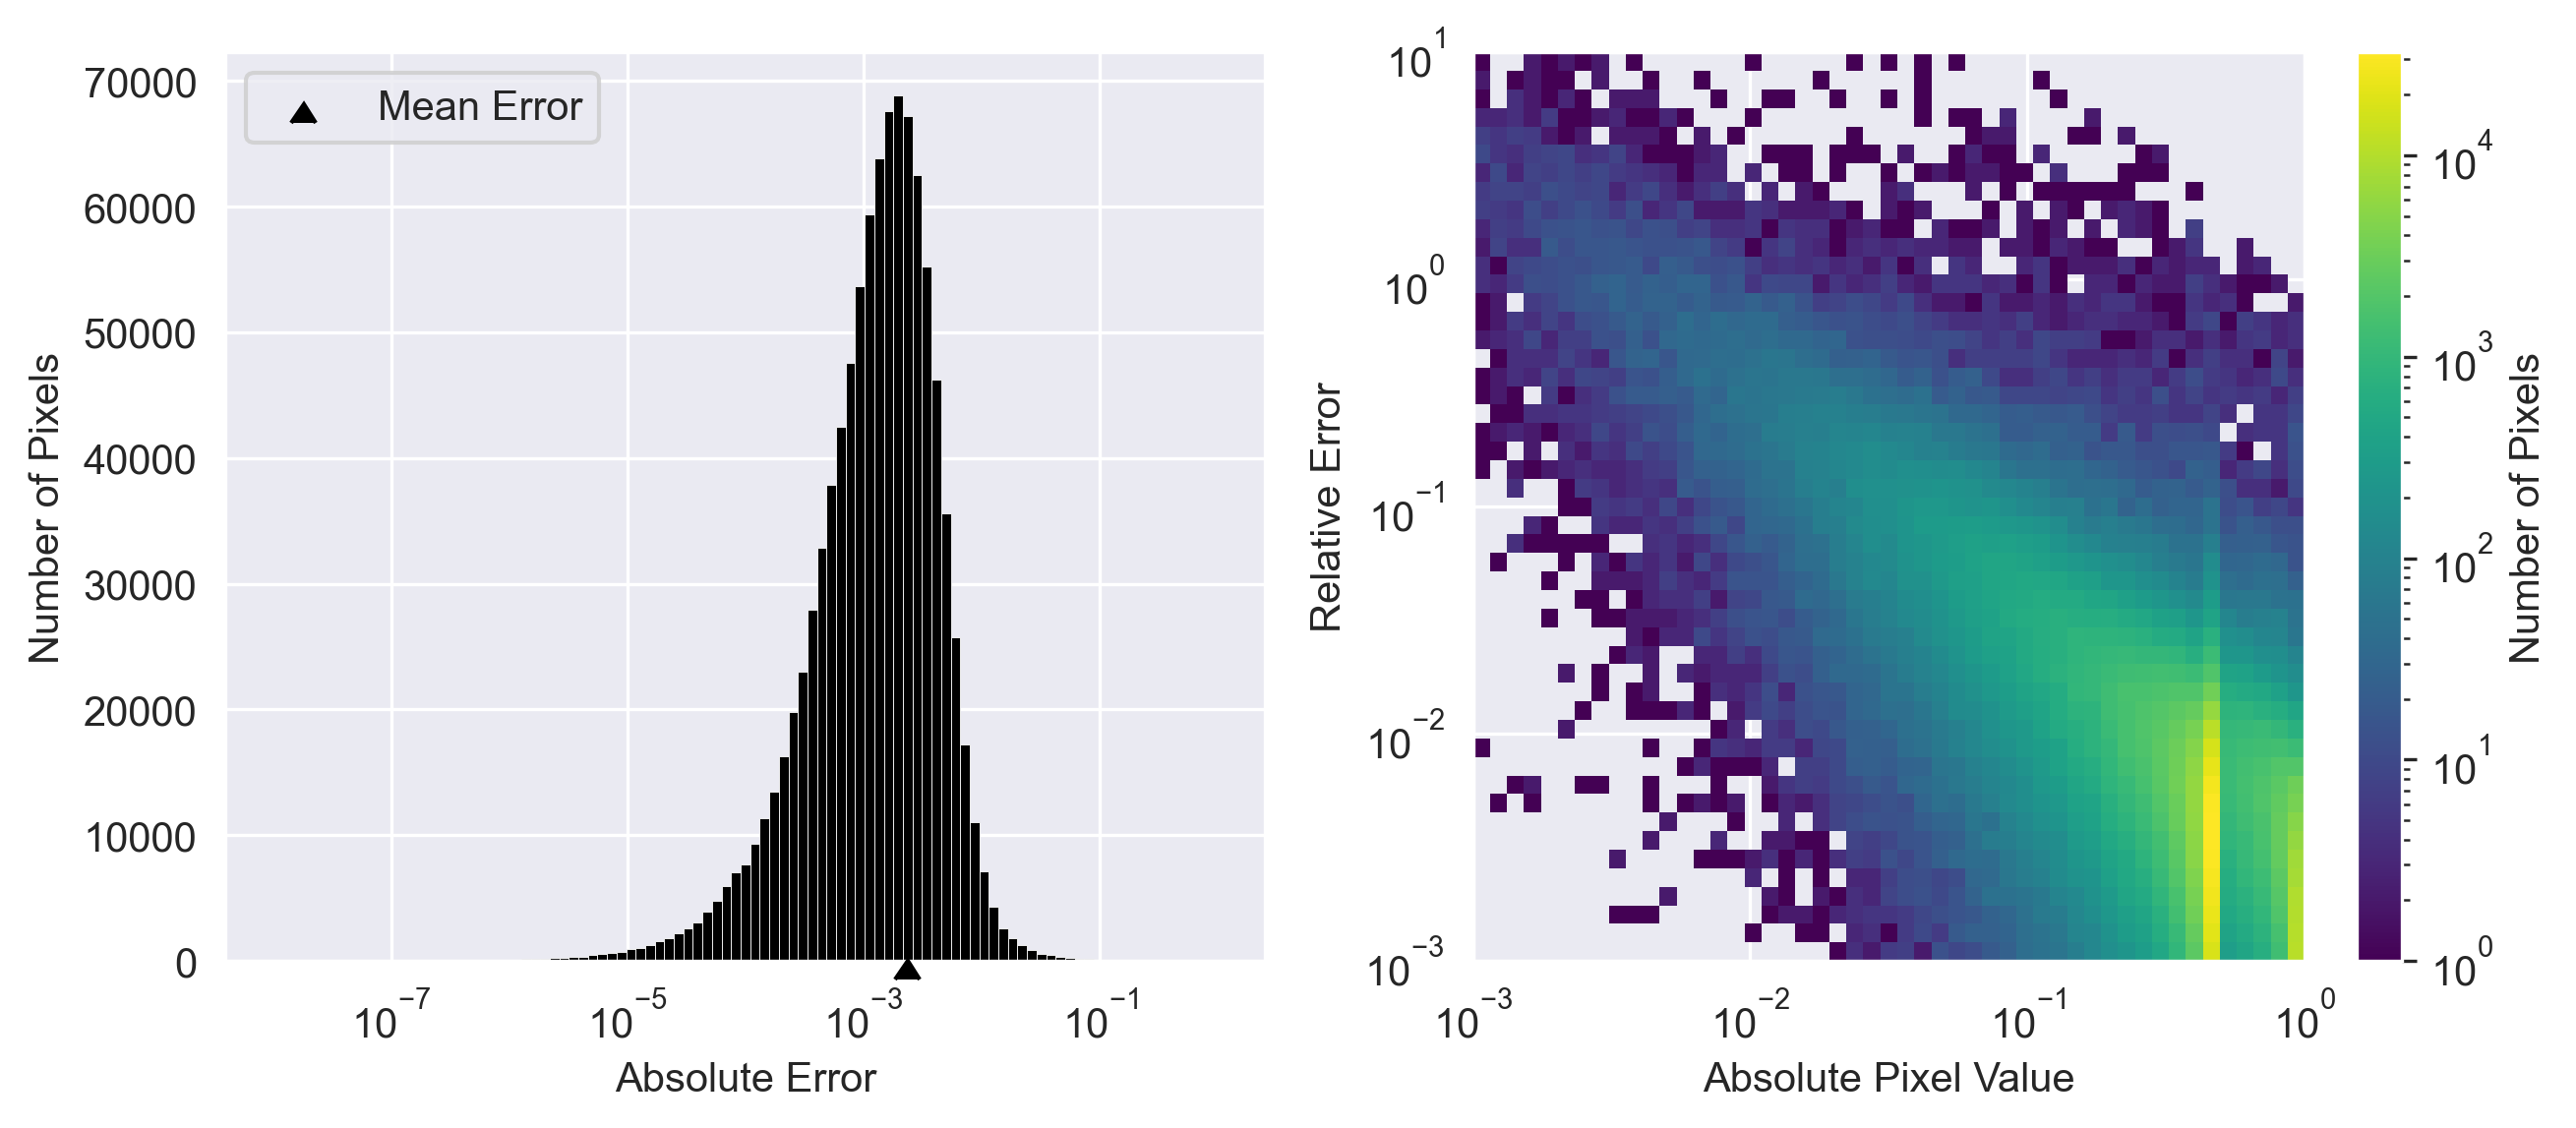

In [10]:
# subplot version of histograms

plt.subplots_adjust(hspace = 0.1, wspace = 0.01)

fig = plt.figure(figsize=(10,4), dpi=300)

haxs = [fig.add_subplot(1,2,i+1) for i in range(2)]

haxs[0].hist(difference_norm.flatten(),bins=np.logspace(np.log10(1e-8),np.log10(1.0), 100), log=False, color='black', linewidth=0.2)
haxs[0].set_xscale("log")
haxs[0].set(xlabel="Absolute Error",ylabel="Number of Pixels")

mean_mark = haxs[0].plot(torch.mean(difference_norm), 0, color = 'black', marker=6,label = 'Mean Error', zorder=10, clip_on=False, linestyle="None")

haxs[0].legend(loc='upper left')

hist_map = seaborn.color_palette(palette='viridis', as_cmap=True)

xbin = np.logspace(np.log10(1e-3),np.log10(1.), 50)
ybin = np.logspace(np.log10(1e-3),np.log10(10), 50)

h2 = haxs[1].hist2d( torch.abs(dataset.flatten()).numpy(), relative_difference_norm.flatten().numpy(), bins=[xbin,ybin], norm = colors.LogNorm(), cmap=hist_map)

haxs[1].set_xscale("log")
haxs[1].set_yscale("log")
haxs[1].set(xlabel="Absolute Pixel Value",ylabel="Relative Error")

fig.colorbar(h2[3], ax=haxs[1], location='right', label = 'Number of Pixels')

plt.savefig(save_path / 'error_analysis_plots_ignition_unstructured.png', format='pdf', bbox_inches='tight', dpi=300)

In [13]:
# print relevant numbers


net_data = {}

#compute average relative reconstruction error
dim = tuple([i for i in range(1, 3)])

n = torch.sqrt(torch.sum((dataset-processed_data)**2, dim=dim))
d = torch.sqrt(torch.sum((dataset)**2, dim=dim))

net_data['avg_relative_mse'] = torch.mean(n/d)
net_data['max_relative_mse'] = torch.max(n/d)
net_data['param_count'] = sum(p.numel() for p in model.parameters() if p.requires_grad)
net_data['data_shape'] = dataset.shape
net_data['avg_mse'] = torch.mean(n)

info_filename = 'network_details.txt'

info_file = save_path / info_filename

with open(info_file, "w") as file:
    for key, value in net_data.items():
        file.write(f"{key}: {value}\n")
        print(f'{key}: {value}\n')

avg_relative_mse: 0.007309701759368181

max_relative_mse: 0.21143905818462372

param_count: 1016206

data_shape: torch.Size([450, 1, 2189])

avg_mse: 0.18980830907821655

